In [3]:
import numpy as np
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
from convolution_lstm import ConvLSTM
from evaluate import Handler

# Data preprocessing

convert "order_XX.txt" into "paired_XX.txt"

In [4]:
def poi_in_axis():
    index_y = np.zeros(400)
    index_x = np.zeros(300)
    with open("../orders/poi_3915.txt", "r") as file_object:
        lines = file_object.readlines()
    for line in lines:
        sp = line.rstrip().split(", ")
        i = int(float(sp[0]) * 2)
        j = int(float(sp[1]) * 2)
        lon = float(sp[2])
        lat = float(sp[3])
        if index_y[i] == 0.0 or index_y[i] > lat:
            index_y[i] = lat
        if index_x[j] == 0.0 or index_x[j] > lon:
            index_x[j] = lon
    return index_y, index_x


class RecordGrid:
    def __init__(self):
        self.ry, self.rx = poi_in_axis()
        self.rgy = 400
        self.rgx = 300

    def find_gridy(self, lat):
        """find the nearest y_grid for current location"""
        for i in range(0, self.rgy):
            if self.ry[i] > lat:
                if self.ry[i - 1] != 0:
                    return (i - 1) / 2
                j = i - 1
                start = self.ry[i] - 0.005
                while self.ry[j] == 0:
                    if start < lat:
                        self.ry[j] = start
                        return j / 2
                    j -= 1
                    start -= 0.005
                return j / 2
        return 0

    def find_gridx(self, lon):
        """find the nearest x_grid for current location"""
        for i in range(0, self.rgx):
            if self.rx[i] > lon:
                if self.rx[i - 1] != 0:
                    return (i - 1) / 2
                j = i - 1
                value = self.rx[i] - 0.005
                while self.rx[j] == 0:
                    if value < lon:
                        self.rx[j] = value
                        return j / 2
                    j -= 1
                    value -= 0.005
                return j / 2
        return 0


def process_time(t):
    """extract day, hour and minute"""
    time_local = time.localtime(int(t))
    return time_local.tm_mday, time_local.tm_hour, time_local.tm_min


def process(line, rg):
    """processing one line of trajectory"""
    spl = line.rstrip().split(",")
    driver_id = spl[0]
    d, uh, um = process_time(spl[1])
    d, oh, om = process_time(spl[2])
    times = ",%d,%d,%d,%d,%d" % (d, uh, um, oh, om)
    # date, pickup_h, pickup_m, dropoff_h, dropoff_m
    lon = float(spl[3])
    lat = float(spl[4])
    uy = rg.find_gridy(lat)
    ux = rg.find_gridx(lon)
    locate_up = ",%f,%f,%.1f,%.1f" % (lon, lat, uy, ux)
    # pickup_lon, pickup_lat, pickup_y, pickup_x
    lon = float(spl[5])
    lat = float(spl[6])
    oy = rg.find_gridy(lat)
    ox = rg.find_gridx(lon)
    locate_off = ",%f,%f,%.1f,%.1f" % (lon, lat, oy, ox)
    # dropoff_lon, dropoff_lat, dropoff_y, dropoff_x
    return driver_id + times + locate_up + locate_off


In [3]:
for i in range(1,21):
    print("*********file %d***********" %i)
#for i in range(1,6):
#for i in range(1,11):
    r = RecordGrid()
    # Change the path below:
    path1 = "../orders/order_%02d.txt" %i
    path2 = "../data_paired/paired_%02d.txt" %i
    with open(path1, "r") as file_object:
        lines = file_object.readlines()
    with open(path2, "w") as file_object:
        i = 0
        for line in lines:
            nl = process(line, r)
            file_object.write(nl + "\n")
            i += 1
            if i % 10000 == 1:
                print("# Written %d lines." % i)


*********file 1***********
# Written 1 lines.
# Written 10001 lines.
# Written 20001 lines.
# Written 30001 lines.
# Written 40001 lines.
# Written 50001 lines.
# Written 60001 lines.
# Written 70001 lines.
# Written 80001 lines.
# Written 90001 lines.
# Written 100001 lines.
# Written 110001 lines.
# Written 120001 lines.
# Written 130001 lines.
# Written 140001 lines.
# Written 150001 lines.
# Written 160001 lines.
# Written 170001 lines.
# Written 180001 lines.
*********file 2***********
# Written 1 lines.
# Written 10001 lines.
# Written 20001 lines.
# Written 30001 lines.
# Written 40001 lines.
# Written 50001 lines.
# Written 60001 lines.
# Written 70001 lines.
# Written 80001 lines.
# Written 90001 lines.
# Written 100001 lines.
# Written 110001 lines.
# Written 120001 lines.
# Written 130001 lines.
# Written 140001 lines.
# Written 150001 lines.
# Written 160001 lines.
# Written 170001 lines.
# Written 180001 lines.
*********file 3***********
# Written 1 lines.
# Written 10001 

Now we have the preprocessed data, and then we need to save them as numpy matrix.

In [5]:
def time_within(he, me, h, m):
    """examine whether (h,m) is within the time window"""
    if h == he and me <= m < me+10:
        return True
    else:
        return False


def parse_line_2(str_object, he, me, mat):
    """parse one line, result stored in param mat"""
    spl = str_object.rstrip().split(",")
    h1 = int(spl[2])
    m1 = int(spl[3])
    if time_within(he, me, h1, m1):
        y = int(float(spl[8]) * 2)
        x = int(float(spl[9]) * 2)
        if y > 0 and x > 0:
            mat[y][x][1] += 1
    h2 = int(spl[4])
    m2 = int(spl[5])
    if time_within(he, me, h2, m2):
        y = int(float(spl[12]) * 2)
        x = int(float(spl[13]) * 2)
        if y > 0 and x > 0:
            mat[y][x][2] += 1


def handle_2(he, me, d):
    """turn the (400,300) matrix into (40, 40)"""
    mat = np.zeros((400, 300, 3), dtype=int)
    file_name = "../data_paired/paired_%02d.txt" % d
    with open(file_name, "r") as file_object:
        lines = file_object.readlines()
    for line in lines:
        parse_line_2(line, he, me, mat)
    for i in range(0, 400):
        for j in range(0, 300):
            mat[i][j][0] = mat[i][j][1] + mat[i][j][2]
    ret = mat[234:274, 140:180, :]
    #print(ret.shape)
    return ret

In [5]:
for day in range(1,21):
    data = np.zeros((144, 40, 40, 3), dtype=int)
    index = 0
    for i in range(0, 24):
        for j in range(0, 60, 10):
            data[index] = handle_2(i, j, day)
            index += 1
        print("# Finish hour %02d" % i)
    path = "../count_map/map%02d.npy" % day
    np.save(path, data)

# Finish hour 00
# Finish hour 01
# Finish hour 02
# Finish hour 03
# Finish hour 04
# Finish hour 05
# Finish hour 06
# Finish hour 07
# Finish hour 08
# Finish hour 09
# Finish hour 10
# Finish hour 11
# Finish hour 12
# Finish hour 13
# Finish hour 14
# Finish hour 15
# Finish hour 16
# Finish hour 17
# Finish hour 18
# Finish hour 19
# Finish hour 20
# Finish hour 21
# Finish hour 22
# Finish hour 23
# Finish hour 00
# Finish hour 01
# Finish hour 02
# Finish hour 03
# Finish hour 04
# Finish hour 05
# Finish hour 06
# Finish hour 07
# Finish hour 08
# Finish hour 09
# Finish hour 10
# Finish hour 11
# Finish hour 12
# Finish hour 13
# Finish hour 14
# Finish hour 15
# Finish hour 16
# Finish hour 17
# Finish hour 18
# Finish hour 19
# Finish hour 20
# Finish hour 21
# Finish hour 22
# Finish hour 23
# Finish hour 00
# Finish hour 01
# Finish hour 02
# Finish hour 03
# Finish hour 04
# Finish hour 05
# Finish hour 06
# Finish hour 07
# Finish hour 08
# Finish hour 09
# Finish hour 

In [6]:
data.shape

(144, 40, 40, 3)

In [6]:
#heat map
def get_hot(access):
    if access == 0:
        return 0
    elif 0 < access <= 6:
        return 1
    elif 6 < access <= 12:
        return 2
    else:
        return 3


def parse_matrix(m):
    r = np.zeros((40, 40), dtype=int)
    for i in range(0, 40):
        for j in range(0, 40):
            r[i][j] = get_hot(m[i][j])
    return r




In [8]:
for d in range(1,21):
    #draw the heat map
    res = np.zeros((144, 40, 40), dtype=int)
    i = 0
    inp = np.load("../count_map/map%02d.npy" % d)
    for h in range(0, 24):
        for m in range(0, 60, 10):
            a = inp[i, :, :, 0]
            b = parse_matrix(a)
            res[i] = b
            i += 1
    np.save("../heat_map/heat%02d.npy" % d, res)

# build LSTM model

In [7]:
import time
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np
from convolution_lstm import ConvLSTM
from evaluate import Handler

# constant variables:
H = 40 # height
W = 40 # width
N = 16 # number of days in training set

def m_reshape(m):
    """reshape to (CH, H, W)"""
    n = np.zeros((2, H, W))
    for i in range(0, H):
        for j in range(0, W):
            n[0][i][j] = m[i][j][0]
            n[1][i][j] = m[i][j][1]
    return n


def normalization(data):
    _range = np.max(data) - np.min(data)
    if _range > 0:
        return (data - np.min(data)) / _range
    else:
        print("# Exception in normalization method: %f %f" % (np.max(data), np.min(data)))
        return np.ones((2, H, W)) / 2


def parse_data(x, y):
    tmp = x[:, :, 1:3]
    tmp = m_reshape(tmp)
    tmp = normalization(tmp)
    inp = torch.zeros(1, 2, H, W)
    inp[0] = torch.from_numpy(tmp)
    tar = torch.zeros(1, H, W)
    tar[0] = torch.from_numpy(y)
    return inp, tar


# test set: 1, 2, 3, 4
class CLSTM(object):
    def __init__(self):
        self.trset = range(1, 17)  # a list of days in train_set
        self.index = 0  # index of "trset"
        self.net = ConvLSTM(input_channels=2, hidden_channels=[4, 8, 8, 4], kernel_size=5, step=9,
            effective_step=[8]).cuda()
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.01)

    def next_day(self, day):
        """determine the next day in training/testing"""
        if day == 0:
            # training
            tmp = self.trset[self.index]
            self.index = (self.index + 1) % N
        else:
            # testing
            tmp = day
            self.index = day
        pathx = "../count_map/map%02d.npy" % tmp
        pathy = "../heat_map/heat%02d.npy" % tmp
        self.inputs = np.load(pathx).astype(float)
        self.targets = np.load(pathy).astype(float)
        #print("# Shift to day %d" % tmp)

    def get_data(self, index):
        inp = self.inputs[index]
        tar = self.targets[index + 1]
        inp, tar = parse_data(inp, tar)
        inp = Variable(inp).cuda()
        tar = Variable(tar).long().cuda()
        return inp, tar

    def forward_m(self, inp):
        output = self.net(inp)
        output = output[0][0].double()
        return output  # (bsize, 4, H, W)

    def train(self):
        for i in range(0, 143):
            inp, tar = self.get_data(i)
            self.optimizer.zero_grad()
            out = self.forward_m(inp)
            loss = self.loss_fn(out, tar)
            loss.backward()
            self.optimizer.step()
            if i == 107:
                print(loss.detach())
                #print("# Day %d" % self.index)

    def save_model(self, step):
        torch.save({'epoch': step+1, 'state_dict': self.net.state_dict(), 'optimizer': self.optimizer.state_dict()},
        "../model/ckpt_%06d.pth.tar" % (step + 1))
        print("# Model of step %d saved." % (step + 1))

    def restore_from_file(self, ckpt):
        file_name = "../model/ckpt_%06d.pth.tar" % ckpt
        model_CKPT = torch.load(file_name)
        self.net.load_state_dict(model_CKPT['state_dict'])
        print("# state_dict of ConvLSTM loaded.")
        self.optimizer.load_state_dict(model_CKPT['optimizer'])

    def test(self, hd):
        layer = nn.Softmax2d()
        for i in range(0, 143):
            inp, tar = self.get_data(i)
            #self.optimizer.zero_grad()  # clear grad for optim
            out = self.forward_m(inp)
            loss = self.loss_fn(out, tar)
            #loss.backward()  # backward
            #self.optimizer.step()
            output = layer(out)
            output = torch.argmax(output, dim=1)
            hd.one_step(tar[0], output[0])
            #if i % 12 == 0:
                #day = self.index
                #print("# Day = %d, Hour = %d" % (day, i / 6))
        return hd


    def test_graph_2(self, cks):
        """output the predicted result"""
        self.inputs=np.load('../data2/mat01.npy').astype(float)
        self.targets=np.load('../deat_map/heat01.npy').astype(float)
        # param cks is a list containing the hours you want to output
        path_out = "../test/model4out_%02d%02d.npy"
        path_tar = "../test/model4tar_%02d%02d.npy"
        layer = nn.Softmax2d()
        day = self.index
        for i in range(0, 143):
            inp, tar = self.get_data(i)
            out = self.forward_m(inp)
            loss = self.loss_fn(out, tar)
            h = i / 6
            if h in cks:
                output = layer(out)
                output = torch.argmax(output, dim=1)
                output = output.detach().cpu()
                path = path_out % (day, h)
                np.save(path, output)
                tar = tar.detach().cpu()
                path = path_tar % (day, h)
                np.save(path, tar)
                print("# Day = %d, Hour = %d" % (day, i / 6))
        print("# Finish day %d" % day)

train the model

In [8]:
def train1(ckpt, max_step):
    """param: start_step, end_step"""
    model = CLSTM()
    if ckpt > 0:
        model.restore_from_file(ckpt)
    for i in range(ckpt, max_step):
        for d in range(0, N):
            model.next_day(0)
            model.train()
        if i % 10 == 1:
            model.save_model(i)
    print("# Training finished.")


In [8]:
#train1(0,100)
train1(100, 150)

# state_dict of ConvLSTM loaded.
tensor(0.6779, device='cuda:0', dtype=torch.float64)
tensor(0.6517, device='cuda:0', dtype=torch.float64)
tensor(0.6731, device='cuda:0', dtype=torch.float64)
tensor(0.6799, device='cuda:0', dtype=torch.float64)
tensor(0.7002, device='cuda:0', dtype=torch.float64)
tensor(0.6975, device='cuda:0', dtype=torch.float64)
tensor(0.6769, device='cuda:0', dtype=torch.float64)
tensor(0.6573, device='cuda:0', dtype=torch.float64)
tensor(0.6642, device='cuda:0', dtype=torch.float64)
tensor(0.6692, device='cuda:0', dtype=torch.float64)
tensor(0.6911, device='cuda:0', dtype=torch.float64)
tensor(0.7001, device='cuda:0', dtype=torch.float64)
tensor(0.7055, device='cuda:0', dtype=torch.float64)
tensor(0.6616, device='cuda:0', dtype=torch.float64)
tensor(0.7270, device='cuda:0', dtype=torch.float64)
tensor(0.6704, device='cuda:0', dtype=torch.float64)
tensor(0.6810, device='cuda:0', dtype=torch.float64)
tensor(0.6752, device='cuda:0', dtype=torch.float64)
tensor(0.6813

In [9]:
def test(ckpt):
    model = CLSTM()
    model.restore_from_file(ckpt)
    hd = Handler()
    for d in range(17, 21):
        model.next_day(d)
        hd = model.test(hd)
        print("# Finish testing day %d" % d)
    hd.get_metrics()

In [16]:
for j in range(50, 80, 2):
    print("# Iteration = %d" % j)
    test(j)

# Iteration = 50
# state_dict of ConvLSTM loaded.
# Finish testing day 17
# Finish testing day 18
# Finish testing day 19
# Finish testing day 20
[[  1543 341060]
 [   544 572053]]
0.7393387637757547 0.004503755075116096 0.008952972235922133
# Iteration = 52
# state_dict of ConvLSTM loaded.
# Finish testing day 17
# Finish testing day 18
# Finish testing day 19
# Finish testing day 20
[[ 83690 258913]
 [ 16628 555969]]
0.8342470942403158 0.24427690358811802 0.3779003479175745
# Iteration = 54
# state_dict of ConvLSTM loaded.
# Finish testing day 17
# Finish testing day 18
# Finish testing day 19
# Finish testing day 20
[[203841 138762]
 [ 62149 510448]]
0.7663483589608632 0.5949772769065069 0.6698762555599554
# Iteration = 56
# state_dict of ConvLSTM loaded.
# Finish testing day 17
# Finish testing day 18
# Finish testing day 19
# Finish testing day 20
[[222823 119780]
 [ 75063 497534]]
0.7480143410566459 0.6503825127042087 0.695790247763818
# Iteration = 58
# state_dict of ConvLSTM lo

# Comparison
Now we choose other classifiers (not neural-based) and conduct comparison experiment.

In [10]:
import numpy as np
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from evaluate import Handler

In [11]:
# constant variables
TEST = 4
TRAIN = 16

def normalization(data):
	_range = np.max(data) - np.min(data)
	return (data - np.min(data)) / _range


def get_input(day, index):
	m = np.load("../count_map/map%02d.npy" % day)[index]
	n = m[:, :, 1:3]
	n = np.reshape(n, (1600, 2))
	data = normalization(n)
	return data


def get_target(day, index):
	m = np.load("../heat_map/heat%02d.npy" % day)[index]
	n = np.reshape(m, 1600)
	return n


def get_train_set(index):
	#trset = [2, 3, 4, 5]
	#trset = range(3, 11)
	#trset = [2, 3, 4, 5, 6, 7, 9, 10]
	trset = range(1, 17)
	d = TRAIN
	train_X = np.zeros((d * 40 * 40, 2))
	train_y = np.zeros(d * 40 * 40)
	i = 0
	for d in trset:
		tmp = get_input(d, index)
		train_X[i:i+1600, :] = tmp
		tar = get_target(d, index + 1)
		train_y[i:i+1600] = tar
	return train_X, train_y


def get_test_set(index):
	#tsset = [1]
	#tsset = [1, 2]
	#tsset = [1, 8]
	tsset = [17, 18, 19, 20]
	n = TEST * 40 * 40
	test_X = np.zeros((n, 2))
	test_y = np.zeros(n)
	i = 0
	for d in tsset:
		inp = get_input(d, index)
		test_X[i:i+1600, :] = inp
		tar = get_target(d, index + 1)
		test_y[i:i+1600] = tar
	return test_X, test_y


def evaluate(rg, y, y_):
	TP = 0
	FN = 0
	FP = 0
	TN = 0
	for i in range(0, rg):
		gt = y[i]
		pd = y_[i]
		if gt >= 1.0 and pd >= 1.0:
			TP += 1
		elif gt >= 1.0 and pd < 1.0:
			FN += 1
		elif gt < 1.0 and pd >= 1.0:
			FP += 1
		else:
			TN += 1
	return (TP, FN, FP, TN)


# different clfs:
# kNN: clf = neighbors.KNeighborsClassifier(n_neighbors=4)
# DT: clf = DecisionTreeClassifier(max_leaf_nodes=8)
# SVM: clf = svm.SVC(decision_function_shape='ovr', kernel='rbf', C=1.0)
# GBDT: clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=7)
def process():
	matrix = np.zeros(4, dtype=int)
	num_test = TEST
	for i in range(0, 143):
		X, y = get_train_set(i)
		# choose one clf from the above:
		clf = clf = svm.SVC(decision_function_shape='ovr', kernel='rbf', C=1.0)
		clf.fit(X, y)
		X1, y1 = get_test_set(i)
		pd = clf.predict(X1)
		matrix = matrix + evaluate(40 * 40 * num_test, y1, pd)
		if i > 0 and i % 6 == 0:
			print("# Hour %d" % (i / 6))
	TP = matrix[0]
	FN = matrix[1]
	FP = matrix[2]
	TN = matrix[3]
	p = TP / (TP + FP)
	r = TP / (TP + FN)
	f = 2*p*r / (p+r)
	print(p, r, f)

In [5]:
process()

# Hour 1
# Hour 2
# Hour 3
# Hour 4
# Hour 5
# Hour 6
# Hour 7
# Hour 8
# Hour 9
# Hour 10
# Hour 11
# Hour 12
# Hour 13
# Hour 14
# Hour 15
# Hour 16
# Hour 17
# Hour 18
# Hour 19
# Hour 20
# Hour 21
# Hour 22
# Hour 23
0.7687828850725141 0.6780443565009482 0.7205682636042182


# Visualization

In [ ]:
#generate heat map
model = CLSTM()
model.restore_from_file(142)
model.test_graph_2(15)

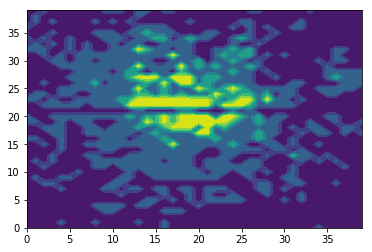

In [35]:
import matplotlib.pyplot as plt
def get_matrix_out(d, h):
    path = "../test/model4out_%02d%02d.npy" % (d, h)
    return np.load(path)[0]


def get_matrix_tar(d, h):
    path = "../test/model4tar_%02d%02d.npy" % (d, h)
    return np.load(path)[0]


def _save(matrix, path):
    """draw contour figures and save it to path"""
    x = range(0, 40)
    y = range(0, 40)
    plt.contourf(x, y, matrix)
    plt.savefig(path)



day = 1
#h = 144
h = 1
for hour in range(h):
    o = get_matrix_out(day, hour)
    t = get_matrix_tar(day, hour)
    path_out = "../graphs/model4out_%02d%02d.png" % (day, hour)
    path_tar = "../graphs/model4tar_%02d%02d.png" % (day, hour)
    _save(o, path_out)
    _save(t, path_tar)



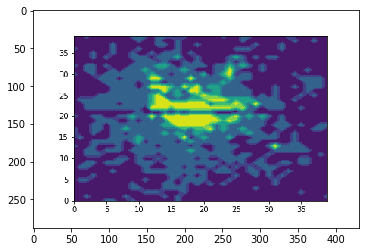

In [38]:
import matplotlib.image as mpimg
predicted = mpimg.imread('../graphs/model4tar_0100.png') 
plt.imshow(predicted)
plt.show()